# Import Libraries

In [2]:
# Run in python console
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy
from spacy.lang.en.examples import sentences 
spacy.cli.download("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('words')
words = set(nltk.corpus.words.words())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /Users/sonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/sonia/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
stop_new = ['mrt', 'station', 'see', 'bus', 'buses', 'line', 'account', 'one', 'full',
                     'get', 'min', 'class', 'year', 'pm', '', 'take', 'taxi', 'allow', 'last', 'almost',
                     'post', 'start', 'cross', 'car_rental', 'comfortdelgro', 'singapore', 'grab',
                     'night', 'find', 'need', 'build', 'photo', 'video', 'leave', 'car', 'train', 
                     'think', 'food', 'make', 'set', 'fresh', 'sbs', 'driver', 'delgro', 'comfort',  
                     'move',  'ever', 'blue', 'uber', 'go', 'look', 'use', 'also', 'give', 
                     'many', 'come', 'lot', 'seem', 'guess', 'definitely', 'sure', 'keep', 'much', 'already', 
                     'do', 'lol', 'people', 'well', 'back', 'week', 'u', 'want', 'day', 'will', 'know', 
                     'even', 'really', 'said', 'say', 'cab', 'public transport', 'taxis', 'public', 
                     'transport', 'thing', 'still', 'got', 'now', 's', 'stop', 'around', 'another', 
                     'smrt', 'next', 'us', 'may', 'person', 'years', 'going', 'trains', 'way', 
                     'seat', 'guy', 'https', 'always', 'riders', 'cabbie', 'sg', 'drivers', 'auntie', 'man', 
                     'uncle', 'stops', 'someone', 'something', 'andy', 'cabs', 'cabbies', 'order', 'delivery', 
                     'gojek', 'quite','fucking', 'every', 'getting', 'trying', 'told', 'something', 'singaporean', 
                     'feel', 'lta', 'fuck', 'without', 'let', 'made', 'getting', 'passenger', 'restaurant', 'grabfood', 
                     'merchant', 'don', 't', 'customer', 'cars', 'actually', 'senior', 'entrepreneur', 'rental', 'cars', 'current']

stop_words.extend(stop_new)

# Import DataFrame

In [6]:
df = pd.read_csv('2020 CSISG Land Transport Data_Clean.csv', encoding='utf-8')

In [7]:
df.head()

,uid,year_of_survey,sub-sector_code,weights_to_account_for_market_share,customer_expectations_score,perceived_overall_quality_score,perceived_value_score,customer_satisfaction_score,customer_loyalty‎/_user_trust_score,trains_sufficient_train_arrival_info,...,point-to-point_transport_ease_of_providing_feedback,point-to-point_transport_ease_of_using_app,point-to-point_transport_accuracy_of_waiting_time_estimation,point-to-point_transport_attractiveness_of_app_promotions_and_discounts,education_qualification,gender,housetype_according_to_respondent,postal_code,verbatim:_reasons_for_their_satisfaction_ratingss,verbatim:_suggested_areas_of_improvement
0,204397,2020,Public Buses,1.091275,92.861895,100.000000,77.777778,92.901742,82.234797,,...,,,,,7,2,4,67,they always greet me good morning and have smi...,"because 972 is a big double decker bus, when i..."
1,208980,2020,Public Buses,0.919861,74.554122,80.834136,78.422920,74.035977,70.106001,,...,,,,,8,2,3,56,Overall ride was positive,Frequency
2,204211,2020,Public Buses,1.091275,96.026993,82.386659,77.777778,85.068707,69.401450,,...,,,,,5,1,4,73,Reliable and fast,NOthing
3,201828,2020,Public Buses,1.091275,77.777778,66.666667,66.666667,77.777778,78.560612,,...,,,,,8,2,3,56,Its pleasant enough,hygiene of the bus
4,203670,2020,Public Buses,1.091275,81.001434,66.666667,83.655904,77.777778,71.515103,,...,,,,,8,2,3,68,Inaccurate bus arrival timing Frequency and ...,Punctuality and frequency


# Prepare DataFrame for Topic Modelling

# Tokenize Each Sentence

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this.
Additionally I have set deacc=True to remove the punctuations.

Create Function

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Execute Function

In [35]:
df_improve_data_words = list(sent_to_words(df['verbatim:_suggested_areas_of_improvement']))

df_satisf_data_words = list(sent_to_words(df['verbatim:_reasons_for_their_satisfaction_ratingss']))
#verbatim:_reasons_for_their_satisfaction_ratingss

In [31]:
df_data_words_improve

[['because',
  'is',
  'big',
  'double',
  'decker',
  'bus',
  'when',
  'it',
  'stops',
  'at',
  'the',
  'bus',
  'stops',
  'it',
  'can',
  'be',
  'quite',
  'scary',
  'as',
  'the',
  'inertia',
  'is',
  'quite',
  'big',
  'so',
  'if',
  'you',
  're',
  'not',
  'holding',
  'on',
  'to',
  'anything',
  'or',
  'sitting',
  'down',
  'chances',
  'are',
  'you',
  'might',
  'shift',
  'little',
  'bit',
  'or',
  'fall',
  'if',
  'you',
  're',
  'not',
  'careful',
  'ho'],
 ['frequency'],
 ['nothing'],
 ['hygiene', 'of', 'the', 'bus'],
 ['punctuality', 'and', 'frequency'],
 ['frequency',
  'of',
  'the',
  'buses',
  'in',
  'the',
  'weekday',
  'morning',
  'as',
  'it',
  'is',
  'feeder',
  'service',
  'and',
  'lot',
  'of',
  'people',
  'commute',
  'to',
  'the',
  'mrt',
  'station',
  'on'],
 ['more', 'frequency', 'of', 'buses', 'lesser', 'arrival', 'timing'],
 ['locations', 'the', 'bus', 'goes', 'to'],
 ['nan'],
 ['occasional', 'interaction', 'with', 'pa

# Build Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document.
Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, 
quadgrams and more.

The two important arguments to Phrases are min_count and threshold.
The higher the values of these param, the harder it is for words to be combined to bigrams.

## Overall

In [42]:
# Improvement
# Build the bigram and trigram models
df_improve_data_bigram = gensim.models.Phrases(df_improve_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_improve_data_trigram = gensim.models.Phrases(df_improve_data_bigram[df_improve_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_improve_data_bigram_mod = gensim.models.phrases.Phraser(df_improve_data_bigram)
df_improve_data_trigram_mod = gensim.models.phrases.Phraser(df_improve_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_improve_data_trigram_mod[df_improve_data_bigram_mod[df_improve_data_words[1]]])

['frequency']


In [43]:
# Satisfaction
# Build the bigram and trigram models
df_satisf_data_bigram = gensim.models.Phrases(df_satisf_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_satisf_data_trigram = gensim.models.Phrases(df_satisf_data_bigram[df_satisf_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_satisf_data_bigram_mod = gensim.models.phrases.Phraser(df_satisf_data_bigram)
df_satisf_data_trigram_mod = gensim.models.phrases.Phraser(df_satisf_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_satisf_data_trigram_mod[df_satisf_data_bigram_mod[df_satisf_data_words[1]]])

['overall', 'ride', 'was', 'positive']


# Define Functions

The bigrams model is ready. Let’s define the functions to remove the stopwords, 
make bigrams and lemmatization and call them sequentially.

In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Call the Functions

## Overall

In [46]:
# Improvement
# Remove Stop Words
df_improve_data_words_nostops = remove_stopwords(df_improve_data_words)

# Form Bigrams
df_improve_data_words_bigrams = make_bigrams(df_improve_data_words_nostops, df_improve_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_improve_data_lemmatized = lemmatization(df_improve_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_improve_data_lemmatized[:1])

[['big', 'scary', 'inertia', 'big', 'hold', 'sit', 'chance', 'shift', 'little', 'bit', 'fall', 'careful']]


In [47]:
# Satisfaction
# Remove Stop Words
df_satisf_data_words_nostops = remove_stopwords(df_satisf_data_words)

# Form Bigrams
df_satisf_data_words_bigrams = make_bigrams(df_satisf_data_words_nostops, df_satisf_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_satisf_data_lemmatized = lemmatization(df_satisf_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_satisf_data_lemmatized[:1])

[['greet', 'good', 'morning', 'smile', 'face', 'ride', 'smooth', 'super', 'patient', 'wheelchair', 'bind', 'commuter']]


# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
# Let’s create them.

## Overall

In [48]:
# Improvement
# Create Dictionary
df_improve_data_id2word = corpora.Dictionary(df_improve_data_lemmatized)

# Create Corpus
df_improve_data_texts = df_improve_data_lemmatized

# Term Document Frequency
df_improve_data_corpus = [df_improve_data_id2word.doc2bow(text) for text in df_improve_data_texts]

# View
print(df_improve_data_corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [49]:
# Create Dictionary
df_satisf_data_id2word = corpora.Dictionary(df_satisf_data_lemmatized)

# Create Corpus
df_satisf_data_texts = df_satisf_data_lemmatized

# Term Document Frequency
df_satisf_data_corpus = [df_satisf_data_id2word.doc2bow(text) for text in df_satisf_data_texts]

# View
print(df_satisf_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


# Build the Topic Model

Gensim creates a unique id for each word in the document.
The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document.

Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]
'addition'

Or, you can see a human-readable form of the corpus itself.

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('maryland_college', 1),
  (..truncated..)]]


Alright, without digressing further let’s jump back on track with the next step:

Building the topic model.

We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.

In [50]:
# Build LDA model
def lda_model(corpus, id2word, n_topics):

    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

In [51]:
df_improve_data_ldamodel = lda_model(df_improve_data_corpus, df_improve_data_id2word, 21)

df_satisf_data_ldamodel = lda_model(df_satisf_data_corpus, df_satisf_data_id2word, 21)
#df_data_ldamodel1 = lda_model(df_data_corpus1, df_data_id2word1, 21)


The above LDA model is built with 20 different topics where each topic is a 
combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of 
each keyword using lda_model.print_topics() as shown next.

The output will look like this...


[(0,
  '0.016*"car" + 0.014*"power" + 0.010*"light" + 0.009*"drive" + 0.007*"mount" '
  '+ 0.007*"controller" + 0.007*"cool" + 0.007*"engine" + 0.007*"back" + '
  '0.006*"turn"'),
 (1,
  '0.072*"line" + 0.066*"organization" + 0.037*"write" + 0.032*"article" + '
  '0.028*"university" + 0.027*"nntp_post" + 0.026*"host" + 0.016*"reply" + '
  '0.014*"get" + 0.013*"thank"'),
 (2,
  '0.017*"patient" + 0.011*"study" + 0.010*"slave" + 0.009*"wing" + '
  '0.009*"disease" + 0.008*"food" + 0.008*"eat" + 0.008*"pain" + '
  '0.007*"treatment" + 0.007*"syndrome"'),
 (3,
  '0.013*"key" + 0.009*"use" + 0.009*"may" + 0.007*"public" + 0.007*"system" + '
  '0.007*"order" + 0.007*"government" + 0.006*"state" + 0.006*"provide" + '
  '0.006*"law"'),
  
  so on...



How to interpret this?

Topic 0 is a represented as _

0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” 
+ 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” 
+ 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are:
‘car’, ‘power’, ‘light’.. and so on
and the weight of ‘car’ on topic 0 is 0.016.

--> The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?
You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?
https://www.machinelearningplus.com/wp-content/uploads/2018/03/Inferring-Topic-from-Keywords.png

In [56]:
df_improve_data_doc_lda = df_improve_data_ldamodel[df_improve_data_corpus]
df_satisf_data_doc_lda = df_satisf_data_ldamodel[df_satisf_data_corpus]

# Calculate Model Perplexity and Topic Coherence

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

## Overall

In [59]:
# Improvement
# Compute Perplexity
print('\nPerplexity: ', df_improve_data_ldamodel.log_perplexity(df_improve_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
df_improve_data_coherence_model_lda = CoherenceModel(model=df_improve_data_ldamodel, texts=df_improve_data_lemmatized, dictionary=df_improve_data_id2word, coherence='c_v')
df_improve_data_coherence_lda = df_improve_data_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', df_improve_data_coherence_lda)



Perplexity:  -18.256853428905835

Coherence Score:  0.49058195911147395


In [60]:
# Satisfaction
# Compute Perplexity
print('\nPerplexity: ', df_satisf_data_ldamodel.log_perplexity(df_satisf_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
df_satisf_data_coherence_model_lda = CoherenceModel(model=df_satisf_data_ldamodel, texts=df_satisf_data_lemmatized, dictionary=df_satisf_data_id2word, coherence='c_v')
df_satisf_data_coherence_lda = df_satisf_data_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', df_satisf_data_coherence_lda)


IndexError: index 1805 is out of bounds for axis 1 with size 1805

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

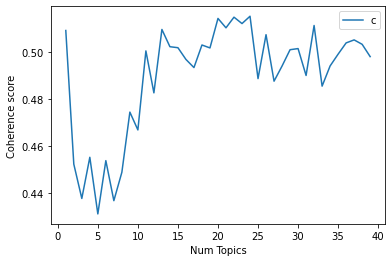

In [61]:
#Improvement
model_list, coherence_values = compute_coherence_values(dictionary=df_improve_data_id2word,
                                                        corpus=df_improve_data_corpus,
                                                        texts=df_improve_data_lemmatized,
                                                        start=1, limit=40, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

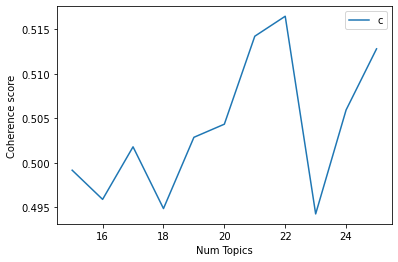

In [63]:
#Improvement - 22
model_list, coherence_values = compute_coherence_values(dictionary=df_improve_data_id2word,
                                                        corpus=df_improve_data_corpus,
                                                        texts=df_improve_data_lemmatized,
                                                        start=15, limit=26, step=1)
# Show graph
import matplotlib.pyplot as plt
start=15; limit=26; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

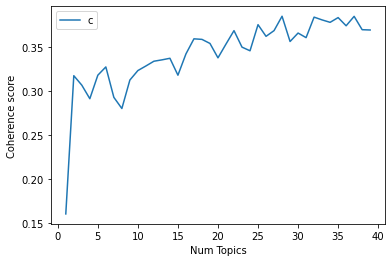

In [64]:
#Satisfaction
model_list1, coherence_values1 = compute_coherence_values(dictionary=df_satisf_data_id2word,
                                                        corpus=df_satisf_data_corpus,
                                                        texts=df_satisf_data_lemmatized,
                                                        start=1, limit=40, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

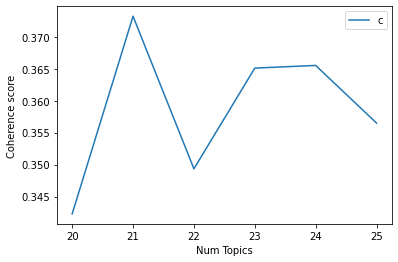

In [65]:
#Satisfaction - 21
model_list1, coherence_values1 = compute_coherence_values(dictionary=df_satisf_data_id2word,
                                                        corpus=df_satisf_data_corpus,
                                                        texts=df_satisf_data_lemmatized,
                                                        start=20, limit=26, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=26; start=20; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualize the topics

Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.

## Overall

In [66]:
#rerun lda model
df_improve_data_ldamodel = lda_model(df_improve_data_corpus, df_improve_data_id2word, 22)

df_satisf_data_ldamodel = lda_model(df_satisf_data_corpus, df_satisf_data_id2word, 21)

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_improve_data_ldamodel,
                              df_improve_data_corpus, 
                              df_improve_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.207457  0.338254       1        1  10.650139
4      0.167857 -0.076910       2        1   9.889175
21     0.154313 -0.034240       3        1   9.229143
15     0.181884 -0.229178       4        1   8.677975
6      0.151478 -0.032969       5        1   7.958950
18     0.122023 -0.013288       6        1   7.955820
20     0.079459 -0.002551       7        1   6.067040
3     -0.019089  0.003758       8        1   5.077142
11    -0.008385  0.003012       9        1   4.946699
19    -0.012433  0.003384      10        1   4.403500
9     -0.062279  0.004148      11        1   3.699105
10    -0.039444  0.003704      12        1   3.301468
0     -0.083109  0.004255      13        1   3.122507
14    -0.074141  0.004062      14        1   3.077123
7     -0.056648  0.004117      15        1   2.868093
13    -0.084897  0.004087      16        1   2.294271
12    -0.105162  0.002961      17        1   1.628767
16    -0.103120  0.003190      18        1   1.352740
1     -0.102165  0.003297      19        1   1.292156
5     -0.103907  0.003113      20        1   1.201543
8     -0.105456  0.002273      21        1   0.884155
17    -0.104236  0.001521      22        1   0.422496, topic_info=            Term        Freq       Total Category  logprob  loglift
53          time  741.000000  741.000000  Default  30.0000   30.000
11     frequency  734.000000  734.000000  Default  29.0000   29.000
25       improve  690.000000  690.000000  Default  28.0000   28.000
15       service  370.000000  370.000000  Default  27.0000   27.000
78          good  240.000000  240.000000  Default  26.0000   26.000
..           ...         ...         ...      ...      ...      ...
616        queue    0.024746    1.451578  Topic22  -7.4983    1.395
617        ridge    0.024746    1.451577  Topic22  -7.4983    1.395
592    variation    0.024746    1.451577  Topic22  -7.4983    1.395
591    programme    0.024746    1.451577  Topic22  -7.4983    1.395
590  orientation    0.024746    1.451586  Topic22  -7.4983    1.395

[860 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
148      20  0.948808        accuracy
83        8  0.784029  air_conditione
138      14  0.963422             app
141      15  0.971732            area
16       11  0.992579         arrival
...     ...       ...             ...
30       16  0.886832     temperature
53        3  0.998313            time
18       11  0.973719          timing
123      15  0.982441          travel
88        3  0.892123             try

[118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 22, 16, 7, 19, 21, 4, 12, 20, 10, 11, 1, 15, 8, 14, 13, 17, 2, 6, 9, 18])

In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_satisf_data_ldamodel,
                              df_satisf_data_corpus, 
                              df_satisf_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.307002  0.311201       1        1  12.186729
14    -0.178835 -0.134959       2        1   9.994888
20    -0.207582 -0.283709       3        1   9.100860
0     -0.028716 -0.004441       4        1   6.460815
3     -0.028416 -0.004177       5        1   6.227276
11    -0.010295  0.000694       6        1   5.854127
9     -0.040125 -0.007359       7        1   5.453406
16    -0.051413 -0.011156       8        1   5.312761
5     -0.032617 -0.005380       9        1   5.256449
7      0.047106  0.009402      10        1   4.257879
13     0.050832  0.010117      11        1   4.135653
8      0.018179  0.005301      12        1   3.986351
15     0.071109  0.012105      13        1   3.605341
12     0.061574  0.011326      14        1   3.535244
1      0.054362  0.010587      15        1   3.222026
18     0.053124  0.010243      16        1   3.099498
2      0.078138  0.012832      17        1   2.891529
6      0.086074  0.013395      18        1   2.224592
17     0.120916  0.014755      19        1   1.308074
19     0.115919  0.014831      20        1   1.188616
10     0.127668  0.014393      21        1   0.697889, topic_info=            Term         Freq        Total Category  logprob  loglift
3           good  1417.000000  1417.000000  Default  30.0000  30.0000
95       service  1093.000000  1093.000000  Default  29.0000  29.0000
133         time   776.000000   776.000000  Default  28.0000  28.0000
7           ride   400.000000   400.000000  Default  27.0000  27.0000
84    experience   260.000000   260.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
303      satisfy     0.037219     1.380434  Topic21  -8.0105   1.3515
266  cleanliness     0.037219     1.380550  Topic21  -8.0105   1.3515
356         easy     0.037220     1.380611  Topic21  -8.0105   1.3514
387       number     0.037218     1.380400  Topic21  -8.0105   1.3515
757        speed     0.037219     1.380540  Topic21  -8.0105   1.3514

[840 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
238       2  0.802978  accessible
181       6  0.906005    accuracy
173       6  0.975187    accurate
140       1  0.984170        area
18        5  0.973076     arrival
...     ...       ...         ...
108       7  0.698496       usual
90        5  0.980945     usually
109       3  0.991957        wait
103      16  0.932927       whole
55        9  0.970323        work

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 15, 21, 1, 4, 12, 10, 17, 6, 8, 14, 9, 16, 13, 2, 19, 3, 7, 18, 20, 11])